## Tasks

- [x] pyspark with mapreduce
    - do these using pyspark
        - [ ] parallelize
        - [x] filter nan values
        - [x] groupby column
- [x] visualization improvements
- [x] so independent would be the thing your testing for (ie. number of libraries in the community ) and the dependent would be number of crimes in the community
- [x] read from hdfs into a pyspark dataframe
- [x] ratio - (community pop for a specific community / total community population for all communities the zip code is in)
- [x] Find the total amount of x for the zip code. If there’s a zipcode that is shared by multiple communities, find the ratio based on the population of each community, and split the amount of x for the zip code based on this ratio.
- [x] i need to first create a table of number of public schools per zip code
    - [x] then create a new table with number of public schools per community area
    - [x] This will help - Team created csv - PopulationPerCommunity.csv
- [x] So we need every factor corresponding to each community area, and the crime rate per community area to do the regression model
 


# Community Crime rate

In [7]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv

--2020-12-04 16:38:59--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [             <=>    ]   1.59G  2.84MB/s    in 9m 34s  

2020-12-04 16:48:33 (2.84 MB/s) - ‘rows.csv’ saved [1706074524]



In [2]:
!pip install geopandas

     |████████████████████████████████| 972kB 6.2MB/s 
     |████████████████████████████████| 6.5MB 21.6MB/s 
     |████████████████████████████████| 14.8MB 3.2MB/s 



## **Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.3.2 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system. The tools installation can be carried out inside the Jupyter Notebook of the Colab. One important note is that if you are new in Spark, it is better to avoid Spark 2.4.0 version since some people have already complained about its compatibility issue with python. 
Follow the steps to install the dependencies:

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

Now that you installed Spark and Java in Colab, it is time to set the environment path which enables you to run Pyspark in your Colab environment. Set the location of Java and Spark by running the following code:

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

Run a local spark session to test your installation:

In [5]:
import findspark
findspark.init()

In [6]:
findspark.find()

'/content/spark-3.0.1-bin-hadoop2.7'

The entry-point of any PySpark program is a SparkContext object. This object allows you to connect to a Spark cluster and create RDDs. The local[*] string is a special string denoting that you’re using a local cluster, which is another way of saying you’re running in single-machine mode. The * tells Spark to create as many worker threads as logical cores on your machine.

In [ ]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

Creating a SparkContext can be more involved when you’re using a cluster. To connect to a Spark cluster, you might need to handle authentication and a few other pieces of information specific to your cluster. You can set up those details similarly to the following:

In [ ]:
# conf = pyspark.SparkConf()
# conf.setMaster('spark://head_node:56887')
# conf.set('spark.authenticate', True)
# conf.set('spark.authenticate.secret', 'secret-key')
# sc = SparkContext(conf=conf)

In [ ]:
from pyspark.sql.functions import to_timestamp,col,lit
crimeDF = spark.read.csv('rows.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a'))
crimeDF.show(50)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|2001-01-01 11:00:00|     016XX E 86TH PL|1153|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false|0412|     004|   8|            45|      

## Data Exploration

In [ ]:
crimeDF.count(), len(crimeDF.columns)

(7238485, 22)

In [ ]:
crimeDF.show(5)

+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|2001-01-01 11:00:00|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false|0412|     004|   8|            45|      11| 

In [ ]:
# First showed the Boolean count of Community Area and Primary Type (Crime Type)
crimeDF.groupBy('Community Area').count().orderBy("count", ascending=False).show(20)

+--------------+------+
|Community Area| count|
+--------------+------+
|          null|613484|
|            25|419257|
|             8|229930|
|            43|217168|
|            23|209287|
|            28|196922|
|            24|194552|
|            29|193549|
|            67|193425|
|            71|188120|
|            49|176841|
|            68|175618|
|            69|164063|
|            66|163088|
|            32|161208|
|            44|144120|
|            22|138714|
|            61|135375|
|             6|132122|
|            26|125514|
+--------------+------+
only showing top 20 rows



In [ ]:
crimeDF.groupBy('Primary Type').count().orderBy("count", ascending=False).show(20)

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1527267|
|             BATTERY|1326031|
|     CRIMINAL DAMAGE| 824446|
|           NARCOTICS| 735061|
|             ASSAULT| 458398|
|       OTHER OFFENSE| 449116|
|            BURGLARY| 407276|
| MOTOR VEHICLE THEFT| 333380|
|  DECEPTIVE PRACTICE| 300709|
|             ROBBERY| 272090|
|   CRIMINAL TRESPASS| 204909|
|   WEAPONS VIOLATION|  85191|
|        PROSTITUTION|  69366|
|PUBLIC PEACE VIOL...|  50717|
|OFFENSE INVOLVING...|  50145|
| CRIM SEXUAL ASSAULT|  28055|
|         SEX OFFENSE|  27628|
|INTERFERENCE WITH...|  17453|
|            GAMBLING|  14594|
|LIQUOR LAW VIOLATION|  14450|
+--------------------+-------+
only showing top 20 rows



In [ ]:
# Print out schema to see what data type Arrest is. It's String type
crimeDF.printSchema() # Thus, in the filter must be string too, 'true'. If boolean type, True

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
crimeDF.select('Year').show(15)

+----+
|Year|
+----+
|2001|
|2017|
|2017|
|2017|
|2017|
|2015|
|2017|
|2017|
|2017|
|2017|
|2017|
|2012|
|2017|
|2017|
|2017|
+----+
only showing top 15 rows



In [ ]:
crimeDF.where(col("Location").isNotNull()).show()

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11665567|   JC234307|2019-04-10 16:37:00|  102XX S VERNON AVE|1562|         SEX OFFENSE|AGGRAVATED CRIMIN...|SCHOOL - PUBLIC B

## Interactive plotly charts
- you can interact with the legends and pie chart

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
tot = crimeDF.count()

CA_pop_per = crimeDF.groupBy("Community_Area") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_community') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_community') / tot) * 100 ) \
  .orderBy('Community_Area') \
  .toPandas()
CA_pop_per

,Community_Area,cnt_per_community,perc_of_count_total
0,NaN,613484,8.475309
1,0.0,76,0.001050
2,1.0,101587,1.403429
3,2.0,83289,1.150641
4,3.0,96408,1.331881
...,...,...,...
74,73.0,78602,1.085890
75,74.0,14799,0.204449
76,75.0,52885,0.730609
77,76.0,39535,0.546178


In [ ]:
fig = go.Figure(data=[go.Pie(labels=CA_pop_per['Community_Area'], values=CA_pop_per['perc_of_count_total'], hovertemplate = "Community no.: %{label} <br>Crime Rate: %{percent}")])
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig.update_traces(textposition='inside', hoverinfo='label+percent',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Crime rate per Community Area')
fig.show()

In [ ]:
data = [go.Bar(x=CA_pop_per['Community_Area'], y=CA_pop_per['perc_of_count_total'], 
               text = 'crime percentage', hovertext=['perc_of_count_total'],
               marker={'color': CA_pop_per['perc_of_count_total'], 'colorscale': 'YlOrRd', "showscale": True}, 
               )]
layout = go.Layout(xaxis=dict(type='category'))
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(
        tickangle = 90,
        title_text = "Community Area",)
fig.update_yaxes(
        title_text = "Crime rate")
fig.update_layout(title="Crime rate by Community Area", hovermode='x')
fig.show()

In [ ]:
tot = crimeDF.count()

crime_per = crimeDF.groupBy("Primary Type") \
  .count() \
  .withColumnRenamed('count', 'crime type') \
  .withColumn('perc_of_count_total', (F.col('crime type') / tot) * 100 ) \
  .orderBy('Primary Type') \
  .toPandas()

In [ ]:
fig = go.Figure(data=[go.Pie(labels=crime_per['Primary Type'], values=crime_per['perc_of_count_total'])])
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig.update_traces(textposition='inside', hoverinfo='label+percent',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Crime types')
fig.show()

In [ ]:
data = [go.Bar(x=crime_per['Primary Type'], y=crime_per['perc_of_count_total'], 
               text = 'crime percentage', hovertext=['perc_of_count_total'],
               marker={'color': crime_per['perc_of_count_total'], 'colorscale': 'YlOrRd', "showscale": True}, 
               )]
layout = go.Layout(xaxis=dict(type='category'))
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(
        tickangle = 90,
        title_text = "Crime Type",)
fig.update_yaxes(
        title_text = "Crime rate")
fig.update_layout(title="Crime rate by Type", hovermode='x')
fig.show()

## Choropleth map

Download **Boundaries - Community Areas (current).geojson**

In [12]:
import folium
import geopandas

In [36]:
ca_boundaries = geopandas.read_file("Boundaries - Community Areas (current).geojson")
ca_boundaries.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [47]:
import pandas as pd
crimePerCapitaDFPandas = crimePerCapitaDF.toPandas()
crimePerCapitaDFPandas['Community Area'] = crimePerCapitaDFPandas['Community Area'].astype(str)

In [48]:
crimePerCapitaDFPandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Community Area  77 non-null     object 
 1   Population2017  77 non-null     object 
 2   Name            77 non-null     object 
 3   count           77 non-null     int64  
 4   perCapitaCrime  77 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.1+ KB


In [90]:
# from branca.element import Figure

# fig=Figure(width=550,height=350)
#definition of the boundaries in the map

Chicago_COORDINATES = (41.895140898, -87.624255632)
district_geo = r'Boundaries - Community Areas (current).geojson'

#creating choropleth map for Chicago District 2016
map1 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
choropleth = folium.Choropleth(geo_data = district_geo,
                data = crimePerCapitaDFPandas,
                columns = ['Community Area', 'perCapitaCrime'],
                key_on = 'feature.properties.area_numbe',
                fill_color='YlOrRd',
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                legend_name = 'Crime rate',
                highlight = True,
                overlay = True).add_to(map1)

# fig.add_child(map1)
# folium.TileLayer('Stamen Terrain').add_to(map1)
# folium.TileLayer('Stamen Toner').add_to(map1)
# folium.TileLayer('Stamen Water Color').add_to(map1)
# folium.TileLayer('cartodbpositron').add_to(map1)
# folium.TileLayer('cartodbdark_matter').add_to(map1)
# folium.LayerControl().add_to(map1)

# Display Region Label
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['community','area_numbe']))
# folium.Choropleth.add_child(
#     folium.features.GeoJsonTooltip(child = ['Name'],labels=True)
# ).add_to(map1)
# choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
#         fields=['NAZEV_NUTS','cena_mean', 'cena_m2_mean'],
#         aliases=['Název kraje', 'Průměrná cena', 'Průměrná cena za m2'],
#         style=('background-color: grey; color: white;')
#         )
# )
map1

Output hidden; open in https://colab.research.google.com to view.

In [78]:
district_geo

'Boundaries - Community Areas (current).geojson'

# Read from hdfs into a pyspark dataframe

In [ ]:
# # You could access HDFS files via full path if no configuration provided.(namenodehost is your localhost if hdfs is located in local environment).
# # For more examples visit:- https://saagie.zendesk.com/hc/en-us/articles/360029759552-PySpark-Read-and-Write-Files-from-HDFS
# from pyspark import SparkContext, SparkConf

# conf = SparkConf().setAppName("myFirstApp").setMaster("local")
# sc = SparkContext(conf=conf)

# textFile = sc.textFile("hdfs://namenodehost/inputFiles/CountOfMonteCristo/BookText.txt")
# textFile.first()

# Optional:- Intersection of zip and community regions

**Upload PopulationPerCommunity.csv**

In [ ]:
import folium
import geopandas
import pandas as pd
comm_boundary = geopandas.read_file("Boundaries - Community Areas (current).geojson")
comm_boundary['area_numbe'] = comm_boundary['area_numbe'].apply(pd.to_numeric) 

Download **Boundaries - ZIP Codes.geojson**

In [ ]:
zip_boundary = geopandas.read_file("Boundaries - ZIP Codes.geojson")
zip_boundary['zip'] = zip_boundary['zip'].apply(pd.to_numeric) 

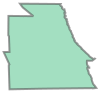

In [ ]:
# 60641
zip_geo = zip_boundary.loc[zip_boundary['zip']==60626]['geometry']
zip_loc = list(zip_geo.keys())[0]
zip_shape = zip_geo[zip_loc]
zip_shape

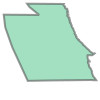

In [ ]:
comm_geo = comm_boundary.loc[comm_boundary['area_numbe']==1]['geometry']
comm_loc = list(comm_geo.keys())[0]
comm_shape = comm_geo[comm_loc]
comm_shape

In [ ]:
comm_shape.overlaps(zip_shape)

True

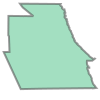

In [ ]:
comm_shape.intersection(zip_shape)

In [ ]:
#calculate coverage 
x = zip_shape.intersection(comm_shape)
print ('Coverage: ', x.area/comm_shape.area*100,'%')

Coverage:  46.762179612136215 %


In [ ]:
def calc_intersection(community_no, zip_code):
    # community_no, zip_code = str(community_no), str(zip_code)
    zip_geo = zip_boundary.loc[zip_boundary['zip']==zip_code]['geometry']
    try:
        zip_loc = list(zip_geo.keys())[0]
    except IndexError:
        return 0, False
    zip_shape = zip_geo[zip_loc]

    comm_geo = comm_boundary.loc[comm_boundary['area_numbe']==community_no]['geometry']
    comm_loc = list(comm_geo.keys())[0]
    comm_shape = comm_geo[comm_loc]

    overlap = comm_shape.overlaps(zip_shape)

    #calculate coverage 
    x = zip_shape.intersection(comm_shape)
    coverage = x.area/comm_shape.area

    return coverage, overlap

In [ ]:
from pyspark.sql.types import StringType
zip_boundary_s = spark.createDataFrame(zip_boundary)
zip_boundary_s = zip_boundary_s.withColumn('zip', f.col('zip').cast(StringType()))

In [ ]:
comm_boundary_s = spark.createDataFrame(comm_boundary)
comm_boundary_s = comm_boundary_s.withColumn('area_numbe', f.col('area_numbe').cast(StringType()))

In [ ]:
comm_boundary_s.printSchema()

root
 |-- community: string (nullable = true)
 |-- area: string (nullable = true)
 |-- shape_area: string (nullable = true)
 |-- perimeter: string (nullable = true)
 |-- area_num_1: string (nullable = true)
 |-- area_numbe: string (nullable = true)
 |-- comarea_id: string (nullable = true)
 |-- comarea: string (nullable = true)
 |-- shape_len: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- __geom__: long (nullable = true)
 |    |-- _is_empty: boolean (nullable = true)
 |    |-- _ndim: long (nullable = true)



In [ ]:
calc_intersection(25,60651)

(0.2475659850371321, True)

In [ ]:
zip_boundary[zip_boundary['zip']==60640]

,objectid,shape_area,shape_len,zip,geometry
14,4,77305245.7089,48985.8713041,60640,"MULTIPOLYGON (((-87.65054 41.98383, -87.65058 ..."


In [ ]:
cp

,Community_Area_2,Zip_Code,intersect
0,1,60626,0.934514
1,1,60645,0.065337
2,1,60660,0.000148
3,2,60626,0.012866
4,2,60645,0.597776
...,...,...,...
229,76,60634,0.098149
230,76,60656,0.107817
231,76,60706,0.000000
232,77,60640,0.366697


In [ ]:
community_zip_intersect_df_p = communityDF.toPandas()

In [ ]:
community_zip_intersect_df_p['intersect'] = community_zip_intersect_df_p.apply(lambda x: calc_intersection(x['Community_Area_2'],x['Zip_Code'])[0], axis=1)

In [ ]:
cp['intersect'] = cp.apply(lambda x: calc_intersection(x['Community_Area_2'],x['Zip_Code'])[0], axis=1)

In [ ]:
cp_s = spark.createDataFrame(cp)

In [ ]:
cp_intersect = cp_s.join(populationDF,cp_s["Community_Area_2"]== populationDF["Community_Area_3"], how = "left").drop(cp_s["Community_Area_2"])

In [ ]:
# # tot = crimepopcommDF.count()

# crime_for_pop = crimepopcommDF.withColumnRenamed('cnt_per_community', 'crime_count') \
#   .withColumnRenamed('2017\xa0population','pop') \
#   .withColumn('crime_per_capita', (F.col('crime_count') / F.col('pop'))) \
#   .orderBy('Community Area') \
#   .drop(crimepopcommDF.perc_of_count_total) \
#   .drop(crimepopcommDF['Community Area']) \
#   .withColumnRenamed('Community Area 3','Community Area') \
#   .toPandas()
# crime_for_pop

In [ ]:
# ppc = ppc.withColumn('2017\xa0population', regexp_replace('2017\xa0population', ',', '').cast(IntegerType()))

In [ ]:
from pyspark.sql.functions import *
zip_comm_intersect = cp_intersect.select('Zip_Code','Community_Area_3','Name','Population2017','intersect') \
    .orderBy('Community_Area_3') \
    .withColumn('Population2017', regexp_replace('Population2017', ',', '').cast(IntegerType())) \
    .withColumn('Zip_Comm_intersect_pop', (F.col('Population2017') * F.col('intersect')).cast(IntegerType()))
zip_comm_intersect.show()

+--------+----------------+--------------+--------------+--------------------+----------------------+
|Zip_Code|Community_Area_3|          Name|Population2017|           intersect|Zip_Comm_intersect_pop|
+--------+----------------+--------------+--------------+--------------------+----------------------+
|   60660|               1|   Rogers Park|         55062|1.482882542216370...|                     8|
|   60645|               1|   Rogers Park|         55062| 0.06533705348802381|                  3597|
|   60626|               1|   Rogers Park|         55062|  0.9345142964071931|                 51456|
|   60630|              10|  Norwood Park|         37089|2.970467627849094E-7|                     0|
|   60656|              10|  Norwood Park|         37089| 0.37794698819418077|                 14017|
|   60631|              10|  Norwood Park|         37089| 0.49341491796333936|                 18300|
|   60646|              10|  Norwood Park|         37089| 0.12863705864918773|    

In [ ]:
zip_code_pop = zip_comm_intersect.select('Zip_Code','Zip_Comm_intersect_pop').orderBy('Zip_Code') \
                  .groupBy("Zip_Code") \
                  .agg(F.sum("Zip_Comm_intersect_pop")) \
                  .withColumnRenamed('sum(Zip_Comm_intersect_pop)','Zip_Code_pop') \
                  .orderBy('Zip_Code')

In [ ]:
schoolDF = spark.read.csv('Chicago_Public_Schools_-_High_School_Progress_Report__2013-2014_.csv',header=True,inferSchema = True)
schoolsubDF = schoolDF.select(['ZIP Code','School ID'])
schoolsubDF.show()

+--------+---------+
|ZIP Code|School ID|
+--------+---------+
|   60603|   610572|
|   60609|   400133|
|   60608|   400148|
|   60628|   400156|
|   60632|   400149|
|   60643|   400147|
|   60628|   609761|
|   60639|   609716|
|   60609|   400010|
|   60652|   609698|
|   60644|   610518|
|   60634|   609732|
|   60616|   400022|
|   60625|   609737|
|   60607|   400036|
|   60622|   400131|
|   60624|   610566|
|   60623|   610357|
|   60649|   610547|
|   60827|   400108|
+--------+---------+
only showing top 20 rows



In [ ]:
schools_count_zip = schoolsubDF.groupBy("Zip Code") \
  .count() \
  .withColumnRenamed('count', 'zip_school_count')
schools_count_zip.show()

+--------+----------------+
|Zip Code|zip_school_count|
+--------+----------------+
|   60642|               3|
|   60647|               1|
|   60627|               1|
|   60623|              11|
|   60640|               3|
|   60625|               4|
|   60643|               5|
|   60621|               7|
|   60624|               8|
|   60639|               5|
|   60602|               2|
|   60609|               7|
|   60614|               1|
|   60613|               1|
|   60659|               3|
|   60618|               6|
|   60651|               5|
|   60632|               5|
|   60637|               2|
|   60620|               6|
+--------+----------------+
only showing top 20 rows



In [ ]:
allZips = communityDF.select("Zip_Code").distinct()

In [ ]:
all_Zip_School_Counts = allZips.join(schools_count_zip,allZips["Zip_Code"]== schools_count_zip["Zip Code"], how = "left").drop(schools_count_zip["Zip Code"])

In [ ]:
all_Zip_School_Counts.show()

+--------+----------------+
|Zip_Code|zip_school_count|
+--------+----------------+
|   60642|               3|
|   60068|            null|
|   60656|            null|
|   60647|               1|
|   60623|              11|
|   60645|            null|
|   60640|               3|
|   60625|               4|
|   60643|               5|
|   60621|               7|
|   60624|               8|
|   60706|            null|
|   60646|            null|
|   60639|               5|
|   60601|            null|
|   60602|               2|
|   60614|               1|
|   60609|               7|
|   60613|               1|
|   60804|            null|
+--------+----------------+
only showing top 20 rows



In [ ]:
all_Zip_School_Counts = all_Zip_School_Counts.na.fill(0)

In [ ]:
all_Zip_School_Counts.count()

67

In [ ]:
zip_comm_intersect.columns

['Zip_Code',
 'Community_Area_3',
 'Name',
 'Population2017',
 'intersect',
 'Zip_Comm_intersect_pop']

In [ ]:
final = all_Zip_School_Counts.join(zip_code_pop,all_Zip_School_Counts["Zip_Code"]== zip_code_pop["Zip_Code"], how = "left").drop(zip_code_pop["Zip_Code"])

In [ ]:
final.count()

67

In [ ]:
all_Zip_School_Counts.select("Zip_Code").distinct().count()

67

In [ ]:
# zip code pop is made based on ratio of community in zip
final.show()

+--------+----------------+------------+
|Zip_Code|zip_school_count|Zip_Code_pop|
+--------+----------------+------------+
|   60609|               7|       69789|
|   60611|               0|       26159|
|   60637|               2|       51200|
|   60068|               0|           0|
|   60612|              10|       46379|
|   60620|               6|       80467|
|   60632|               5|      103505|
|   60645|               0|       49156|
|   60616|               9|       52529|
|   60602|               2|        3753|
|   60608|              10|       77614|
|   60106|               0|           0|
|   60634|               2|       78628|
|   60629|               4|      104725|
|   60654|               0|       16448|
|   60007|               0|           0|
|   60618|               6|       90324|
|   60636|               3|       39127|
|   60631|               2|       30341|
|   60655|               1|       28805|
+--------+----------------+------------+
only showing top

In [ ]:
final.printSchema()

root
 |-- Zip_Code: integer (nullable = true)
 |-- zip_school_count: long (nullable = true)
 |-- Zip_Code_pop: long (nullable = true)



In [ ]:
# schools per capita
schools_per_capita = final.withColumn('schools_per_capita', (F.col('zip_school_count') / F.col('Zip_Code_pop')))

In [ ]:
schools_per_capita = schools_per_capita.na.fill(0)

In [ ]:
schools_per_capita.show()

+--------+----------------+------------+--------------------+
|Zip_Code|zip_school_count|Zip_Code_pop|  schools_per_capita|
+--------+----------------+------------+--------------------+
|   60609|               7|       69789|1.003023399103010...|
|   60611|               0|       26159|                 0.0|
|   60637|               2|       51200|          3.90625E-5|
|   60068|               0|           0|                 0.0|
|   60612|              10|       46379|2.156148256754134...|
|   60620|               6|       80467|7.456472839797681E-5|
|   60632|               5|      103505|4.830684507994783E-5|
|   60645|               0|       49156|                 0.0|
|   60616|               9|       52529|1.713339298292371...|
|   60602|               2|        3753|5.329070077271516E-4|
|   60608|              10|       77614|1.288427345581982...|
|   60106|               0|           0|                 0.0|
|   60634|               2|       78628|2.543623136796052E-5|
|   6062

In [ ]:
zip_comm_intersect.show()

+--------+----------------+--------------+--------------+--------------------+----------------------+
|Zip_Code|Community_Area_3|          Name|Population2017|           intersect|Zip_Comm_intersect_pop|
+--------+----------------+--------------+--------------+--------------------+----------------------+
|   60626|               1|   Rogers Park|         55062|  0.9345142964071931|                 51456|
|   60645|               1|   Rogers Park|         55062| 0.06533705348802381|                  3597|
|   60660|               1|   Rogers Park|         55062|1.482882542216370...|                     8|
|   60656|              10|  Norwood Park|         37089| 0.37794698819418077|                 14017|
|   60631|              10|  Norwood Park|         37089| 0.49341491796333936|                 18300|
|   60646|              10|  Norwood Park|         37089| 0.12863705864918773|                  4771|
|   60630|              10|  Norwood Park|         37089|2.970467627849094E-7|    

In [ ]:
all_intersections = zip_comm_intersect.toPandas()[['Zip_Code','Community_Area_3','intersect']]

In [ ]:
all_intersections

,Zip_Code,Community_Area_3,intersect
0,60626,1,9.345143e-01
1,60645,1,6.533705e-02
2,60660,1,1.482883e-04
3,60630,10,2.970468e-07
4,60631,10,4.934149e-01
...,...,...,...
229,60611,8,2.942793e-01
230,60642,8,1.350708e-01
231,60654,8,1.558609e-01
232,60068,9,0.000000e+00


In [ ]:
grouped_df = all_intersections.groupby("Community_Area_3")
maximums = grouped_df.max()
largest_comm_in_zip = maximums.reset_index()
largest_comm_in_zip_s = spark.createDataFrame(largest_comm_in_zip)

In [ ]:
all_intersections_s = spark.createDataFrame(all_intersections)

- schools per community = intersect * schools per zip code
- then group by and sum the schools per community based on community (group_by(community))

In [ ]:
school_join = all_intersections_s.join(all_Zip_School_Counts, all_intersections_s["Zip_Code"]== all_Zip_School_Counts["Zip_Code"], how = "left").drop(all_Zip_School_Counts["Zip_Code"])

In [ ]:
school_join.show()

+--------+----------------+--------------------+----------------+
|Zip_Code|Community_Area_3|           intersect|zip_school_count|
+--------+----------------+--------------------+----------------+
|   60626|               1|  0.9345142964071931|               2|
|   60645|               1| 0.06533705348802381|               0|
|   60660|               1|1.482882542216370...|               2|
|   60630|              10|2.970467627849094E-7|               0|
|   60631|              10| 0.49341491796333936|               2|
|   60646|              10| 0.12863705864918773|               0|
|   60656|              10| 0.37794698819418077|               0|
|   60630|              11|  0.7378830146591712|               0|
|   60646|              11|   0.262116932543342|               0|
|   60630|              12| 0.11614489361884979|               0|
|   60646|              12|  0.8795417910362875|               0|
|   60659|              12|0.004313130388325...|               3|
|   60714|

In [ ]:
school_per_community = school_join.withColumn("school_per_community_ratio", (F.col("intersect")*F.col("zip_school_count") )) \
                                  .orderBy("Community_Area_3")
school_per_community.show()

+--------+----------------+--------------------+----------------+--------------------------+
|Zip_Code|Community_Area_3|           intersect|zip_school_count|school_per_community_ratio|
+--------+----------------+--------------------+----------------+--------------------------+
|   60626|               1|  0.9345142964071931|               2|        1.8690285928143862|
|   60645|               1| 0.06533705348802381|               0|                       0.0|
|   60660|               1|1.482882542216370...|               2|      2.965765084432740...|
|   60630|              10|2.970467627849094E-7|               0|                       0.0|
|   60656|              10| 0.37794698819418077|               0|                       0.0|
|   60631|              10| 0.49341491796333936|               2|        0.9868298359266787|
|   60646|              10| 0.12863705864918773|               0|                       0.0|
|   60646|              11|   0.262116932543342|               0|     

- school per capita
    - select Community_Area_3, intersect, school_per_community_ratio
    - Add population column
    - group by communities, add all school_per_community_ratio_count and intersect (for verification)

In [ ]:
populationDF.show()

+----------------+---------------+--------------+
|Community_Area_3|           Name|Population2017|
+----------------+---------------+--------------+
|               1|    Rogers Park|        55,062|
|               2|     West Ridge|        76,215|
|               3|         Uptown|        57,973|
|               4| Lincoln Square|        41,715|
|               5|   North Center|        35,789|
|               6|      Lake View|       100,470|
|               7|   Lincoln Park|        67,710|
|               8|Near North Side|        88,893|
|               9|    Edison Park|        11,605|
|              10|   Norwood Park|        37,089|
|              11| Jefferson Park|        26,808|
|              12|    Forest Glen|        19,019|
|              13|     North Park|        18,842|
|              14|    Albany Park|        51,992|
|              15|   Portage Park|        64,307|
|              16|    Irving Park|        54,606|
|              17|        Dunning|        43,689|


In [ ]:
populationDF = populationDF.withColumn('Population2017', regexp_replace('Population2017', ',', '').cast(IntegerType())) \

In [ ]:
communities_combined = school_per_community.select("Community_Area_3","school_per_community_ratio", "intersect") \
                               .groupBy("Community_Area_3") \
                               .agg(F.sum("school_per_community_ratio"), F.sum("intersect")) \
                               .withColumnRenamed('sum(school_per_community_ratio)','schools_in_community')

In [ ]:
school_population_per_community = communities_combined.join(populationDF,communities_combined["Community_Area_3"]== populationDF["Community_Area_3"], how = "left").drop(populationDF["Community_Area_3"])

In [ ]:
school_population_per_community.show()

+----------------+--------------------+------------------+------------------+--------------+
|Community_Area_3|schools_in_community|    sum(intersect)|              Name|Population2017|
+----------------+--------------------+------------------+------------------+--------------+
|               1|  1.8693251693228294|0.9999996381494385|       Rogers Park|         55062|
|              10|  0.9868298359266787|0.9999992618534708|      Norwood Park|         37089|
|              11|                 0.0|0.9999999472025132|    Jefferson Park|         26808|
|              12|0.012939391164975025|0.9999998150434624|       Forest Glen|         19019|
|              13|  2.3210757802737207|0.9999998523531415|        North Park|         18842|
|              14|   2.686369835340062|1.0000000000000067|       Albany Park|         51992|
|              15|   2.383898313445837|0.9999999879044981|      Portage Park|         64307|
|              16|     4.6377397678148|0.9999999619909836|       Irvin

In [ ]:
# schools per capita
schools_per_capita_final = school_population_per_community.withColumn('schools_per_capita(per_community)', (F.col('schools_in_community') / F.col('Population2017'))).select("Community_Area_3","Name","schools_per_capita(per_community)")

In [ ]:
schools_per_capita_final.show()

+----------------+------------------+---------------------------------+
|Community_Area_3|              Name|schools_per_capita(per_community)|
+----------------+------------------+---------------------------------+
|               1|       Rogers Park|             3.394946005090315E-5|
|              10|      Norwood Park|             2.660707584261314E-5|
|              11|    Jefferson Park|                              0.0|
|              12|       Forest Glen|             6.803402473828816E-7|
|              13|        North Park|             1.231862742953890...|
|              14|       Albany Park|             5.166890743460651...|
|              15|      Portage Park|             3.707058816996341E-5|
|              16|       Irving Park|             8.493095571576017E-5|
|              17|           Dunning|             4.425351503056769E-5|
|              18|         Montclare|             6.028389581605338E-5|
|              19|    Belmont Cragin|             5.055233733002

In [ ]:
lr_data = crimePerCapitaDF.join(schools_per_capita_final, crimePerCapitaDF["Community_Area"]==schools_per_capita_final["Community_Area_3"], how="left") \
                .drop(schools_per_capita_final["Community_Area_3"]).drop(schools_per_capita_final["Name"])

In [ ]:
lr_data.show()

+--------------+--------------+-----+--------------------+------------------+--------------------+
|Community_Area|Population2017|count|      perCapitaCrime|              Name|    perCapitaSchools|
+--------------+--------------+-----+--------------------+------------------+--------------------+
|            31|         32888| 2633| 0.08005959620530284|   Lower West Side|3.012332365041738...|
|            65|         33108| 1877| 0.05669324634529419|         West Lawn|1.183279311089463...|
|            53|         27742| 4001| 0.14422175762381947|      West Pullman|1.992199061326022E-4|
|            34|         13455| 1019| 0.07573392790784095|     Armour Square|6.415186669481436E-4|
|            28|         62872| 9065| 0.14418182974933197|    Near West Side|9.805917760677043E-5|
|            76|         12377| 1688| 0.13638199886886967|            O'Hare|2.157052691276534E-5|
|            26|         17163| 5376|  0.3132319524558644|West Garfield Park|4.637889512128337...|
|         

### Rough

In [ ]:
final = all_Zip_School_Counts.join(zip_code_pop,all_Zip_School_Counts["Zip_Code"]== zip_code_pop["Zip_Code"], how = "left").drop(zip_code_pop["Zip_Code"])

In [ ]:
schools_per_capita.printSchema()

root
 |-- Zip_Code: integer (nullable = true)
 |-- zip_school_count: long (nullable = true)
 |-- Zip_Code_pop: long (nullable = true)
 |-- schools_per_capita: double (nullable = false)



In [ ]:
schools_per_capita.show()

+--------+----------------+------------+--------------------+
|Zip_Code|zip_school_count|Zip_Code_pop|  schools_per_capita|
+--------+----------------+------------+--------------------+
|   60609|               7|       69789|1.003023399103010...|
|   60611|               0|       26159|                 0.0|
|   60637|               2|       51200|          3.90625E-5|
|   60068|               0|           0|                 0.0|
|   60612|              10|       46379|2.156148256754134...|
|   60620|               6|       80467|7.456472839797681E-5|
|   60632|               5|      103505|4.830684507994783E-5|
|   60645|               0|       49156|                 0.0|
|   60616|               9|       52529|1.713339298292371...|
|   60602|               2|        3753|5.329070077271516E-4|
|   60608|              10|       77614|1.288427345581982...|
|   60106|               0|           0|                 0.0|
|   60634|               2|       78628|2.543623136796052E-5|
|   6062

In [ ]:
from pyspark.sql.functions import *
zip_comm_intersect = cp_intersect.select('Zip_Code','Community_Area_3','Name','Population2017','intersect') \
    .orderBy('Community_Area_3') \
    .withColumn('Population2017', regexp_replace('Population2017', ',', '').cast(IntegerType())) \
    .withColumn('Zip_Comm_intersect_pop', (F.col('Population2017') * F.col('intersect')).cast(IntegerType()))
zip_comm_intersect.show()

In [ ]:
final2 = schools_per_capita.join(largest_comm_in_zip_s, schools_per_capita["Zip_Code"]==largest_comm_in_zip_s["Zip_Code"], how = "left").drop(largest_comm_in_zip_s["Zip_Code"])

In [ ]:
final2.show()

+--------+----------------+------------+--------------------+----------------+-------------------+
|Zip_Code|zip_school_count|Zip_Code_pop|  schools_per_capita|Community_Area_3|          intersect|
+--------+----------------+------------+--------------------+----------------+-------------------+
|   60609|               7|       69789|1.003023399103010...|              37|                1.0|
|   60609|               7|       69789|1.003023399103010...|              61| 0.9999999920929274|
|   60611|               0|       26159|                 0.0|            null|               null|
|   60637|               2|       51200|          3.90625E-5|              40| 0.5116182792931923|
|   60637|               2|       51200|          3.90625E-5|              41| 0.5569494740362996|
|   60637|               2|       51200|          3.90625E-5|              69|0.43916298659262626|
|   60068|               0|           0|                 0.0|            null|               null|
|   60612|

- per capita crime
- per capita school
    - get schools per community
    - avoid repeating communities - selected community with largest share in zip
        - join school per zip with largest_comm_in_zip
        - 

# crime per capita

with the 2 ratios: 
1. crime in community/population of community
2. number of schools/population of community

In [ ]:
CA_pop_per_null_removed

In [ ]:
from pyspark.sql.functions import col
 
# load community code into dataframe
#for the purposes of loading a larger dataset and doing joins 
communityDF = spark.read.format("csv").load("/content/Community area and zip code equivalency - Community area and zip code equ.csv", header = True, inferSchema = True)
communityDF.show()

In [ ]:
populationDF = spark.read.format("csv").load("PopulationPerCommunity.csv", header = True, inferSchema = True)
#differentiate columns bc dataframes allow for multiple cols with same name 
populationDF = populationDF.withColumnRenamed("Community Area","Community Area 3")
populationDF.show()

In [ ]:
# pandas df to spark df
crime_comm = spark.createDataFrame(com_per_null_removed)

crime_comm.show()

In [ ]:
crimepopcommDF = populationDF.join(crime_comm,populationDF["Community Area 3"] == crime_comm["Community Area"],how = "inner")
crimepopcommDF.show()

In [ ]:
crimepopcommDF.printSchema()

In [ ]:
crimepopcommDF = crimepopcommDF.withColumn('2017\xa0population', regexp_replace('2017\xa0population', ',', '').cast(IntegerType()))

In [ ]:
# tot = crimepopcommDF.count()

crime_for_pop = crimepopcommDF.withColumnRenamed('cnt_per_community', 'crime_count') \
  .withColumnRenamed('2017\xa0population','pop') \
  .withColumn('crime_per_capita', (F.col('crime_count') / F.col('pop'))) \
  .orderBy('Community Area') \
  .drop(crimepopcommDF.perc_of_count_total) \
  .drop(crimepopcommDF['Community Area']) \
  .withColumnRenamed('Community Area 3','Community Area') \
  .toPandas()
crime_for_pop

In [ ]:
fig = go.Figure(data=[go.Pie(labels=crime_for_pop['Name'], values=crime_for_pop['crime_per_capita'])])
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig.update_traces(textposition='inside', hoverinfo='label+percent',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Crime per capita')
fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
data = [go.Bar(x=crime_for_pop['Name'], y=crime_for_pop['crime_per_capita'], 
               text = 'crime per capita', hovertext=['crime_per_capita'],
               marker={'color': crime_for_pop['crime_per_capita'], 'colorscale': 'YlOrRd', "showscale": True}, 
               )]
layout = go.Layout(xaxis=dict(type='category'))
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(
        tickangle = 90,
        title_text = "Community Area",)
fig.update_yaxes(
        title_text = "Crime count")
fig.update_layout(title="Crime per capita", hovermode='x')
fig.show()

# no. of schools per capita

In [ ]:
# Clean data 
#Rename columns in community area to match crimeDF 
communityDF = communityDF.withColumnRenamed("CHGOCA","Community Area 2")
communityDF = communityDF.withColumnRenamed("ZCTA5", "Zip Code")
#Drop TOT2010 not necessary column
communityDF  = communityDF.drop("TOT2010")
communityDF.show()

In [ ]:
crimeDF = spark.read.csv('rows.csv',header=True,inferSchema = True)
crimeDF.show()

In [ ]:
#create SQL
communityDF.createOrReplaceTempView("communityCodes")

In [ ]:
# add zip code to crime data set 
crimeZipDF = crimeDF.join(communityDF,crimeDF["Community Area"] == communityDF["Community Area 2"],how = "left") 
crimeZipPopDf = crimeZipDF.join(populationDF, crimeZipDF["Community Area"] == populationDF["Community Area 3"],how = "left")

In [ ]:
crimeZipPopDf.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+----------------+--------+----------------+------------------+---------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|Community Area 2|Zip Code|Community Area 3|              Name|2017 population|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+----------------+--------+---

In [ ]:
colsDrop = ("ID","Case Number","IUCR","Beat","District","Ward","FBI Code","X Coordinate","Y Coordinate", "Latitude","Longditude","Location","Community Area 2","Community Area 3")
cleanedDFFinal = crimeZipPopDf.drop(*colsDrop)
cleanedDFFinal.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------+--------------+----+--------------------+---------+--------+------------------+---------------+
|                Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Community Area|Year|          Updated On|Longitude|Zip Code|              Name|2017 population|
+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------+--------------+----+--------------------+---------+--------+------------------+---------------+
|01/01/2001 11:00:...|     016XX E 86TH PL|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false|            45|2001|08/05/2017 03:50:...|     null|   60619|       Avalon Park|          9,985|
|01/01/2001 11:00:...|     016XX E 86TH PL|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false|      

In [ ]:
schoolDF = spark.read.csv('Chicago_Public_Schools_-_High_School_Progress_Report__2013-2014_.csv',header=True,inferSchema = True)
schoolsubDF = schoolDF.select(['School ID','Name of School','Street Address','ZIP Code'])
schoolsubDF.show()

+---------+--------------------+--------------------+--------+
|School ID|      Name of School|      Street Address|ZIP Code|
+---------+--------------------+--------------------+--------+
|   610572|Camelot Safe Acad...|      125 S Clark St|   60603|
|   400133|YCCS-Innovations ...|       220 W 45th Pl|   60609|
|   400148|Instituto Justice...|2570 S Blue Islan...|   60608|
|   400156|Noble Street Char...|      821 E 103rd St|   60628|
|   400149|UNO Soccer Academ...| 5025 S St Louis Ave|   60632|
|   400147|Chicago Excel Aca...|     1269 W 111th St|   60643|
|   609761|George H Corliss ...|      821 E 103rd St|   60628|
|   609716|Kelvyn Park High ...|4343 W Wrightwood...|   60639|
|   400010|Architecture, Con...|     5410 S State St|   60609|
|   609698|William J Bogan H...|      3939 W 79th St|   60652|
|   610518|VOISE Academy Hig...|      231 N Pine Ave|   60644|
|   609732|Charles P Steinme...|   3030 N Mobile Ave|   60634|
|   400022|Chicago High Scho...|       521 E 35th St|  

In [ ]:
schoolsubDF.count()

188

In [ ]:
# distinct zip codes
# https://stackoverflow.com/a/39384987/9292995
# len(schoolsubDF.select('ZIP Code').distinct().rdd.map(lambda r: r[0]).collect())
"There are a total of {} zip codes with schools".format(len(schoolsubDF.toPandas()['ZIP Code'].unique()))

'There are a total of 46 zip codes with schools'

In [ ]:
schoolsubDF.orderBy('ZIP Code').show()

+---------+--------------------+--------------------+--------+
|School ID|      Name of School|      Street Address|ZIP Code|
+---------+--------------------+--------------------+--------+
|   400162|Intrinsic Charter HS|       17 N State St|   60602|
|   400098|Noble Street Char...|        1 N State St|   60602|
|   610572|Camelot Safe Acad...|      125 S Clark St|   60603|
|   610573|Camelot Safe Acad...|      125 S Clark St|   60603|
|   609678|William Jones Col...|      700 S State St|   60605|
|   609755|Whitney M Young M...|     211 S Laflin St|   60607|
|   400036|Chicago Virtual C...|      38 S Peoria St|   60607|
|   400091|Chicago Technolog...|      1301 W 14th St|   60608|
|   400148|Instituto Justice...|2570 S Blue Islan...|   60608|
|   400135|YCCS-Latino Youth...|2001 S California...|   60608|
|   400104|Instituto Health ...|  2520 S Western Ave|   60608|
|   400164|Instituto Charter...|  2520 S Western Ave|   60608|
|   400102|Urban Prep Academ...|      1326 W 14th Pl|  

In [ ]:
communityDF.show()

+----------------+--------+
|Community Area 2|Zip Code|
+----------------+--------+
|               1|   60626|
|               1|   60645|
|               1|   60660|
|               2|   60626|
|               2|   60645|
|               2|   60659|
|               2|   60660|
|               3|   60613|
|               3|   60640|
|               4|   60618|
|               4|   60625|
|               4|   60640|
|               4|   60659|
|               4|   60660|
|               5|   60613|
|               5|   60614|
|               5|   60618|
|               5|   60657|
|               6|   60613|
|               6|   60614|
+----------------+--------+
only showing top 20 rows



In [ ]:
schoolcleanfinalDF = communityDF.join(schoolsubDF,communityDF["ZIP Code"] == schoolsubDF["ZIP Code"],how = "left").drop(schoolsubDF["ZIP Code"]) 
schoolcleanfinalDF.show()

+----------------+--------+---------+--------------------+--------------------+
|Community Area 2|Zip Code|School ID|      Name of School|      Street Address|
+----------------+--------+---------+--------------------+--------------------+
|               1|   60626|   400035|Chicago Math and ...|     7212 N Clark St|
|               1|   60626|   609733|Roger C Sullivan ...| 6631 N Bosworth Ave|
|               1|   60645|     null|                null|                null|
|               1|   60660|   609730|Nicholas Senn Hig...| 5900 N Glenwood Ave|
|               1|   60660|   610390|Hyman G Rickover ...| 5900 N Glenwood Ave|
|               2|   60626|   400035|Chicago Math and ...|     7212 N Clark St|
|               2|   60626|   609733|Roger C Sullivan ...| 6631 N Bosworth Ave|
|               2|   60645|     null|                null|                null|
|               2|   60659|   400034|Chicago Intl Char...| 3900 W Peterson Ave|
|               2|   60659|   609724|Ste

In [ ]:
schoolcleanfinalDF.orderBy('Name of School').show()

+----------------+--------+---------+--------------+--------------+
|Community Area 2|Zip Code|School ID|Name of School|Street Address|
+----------------+--------+---------+--------------+--------------+
|              12|   60646|     null|          null|          null|
|              32|   60606|     null|          null|          null|
|               5|   60657|     null|          null|          null|
|              14|   60630|     null|          null|          null|
|               6|   60657|     null|          null|          null|
|              15|   60630|     null|          null|          null|
|               8|   60654|     null|          null|          null|
|              15|   60706|     null|          null|          null|
|               1|   60645|     null|          null|          null|
|              16|   60630|     null|          null|          null|
|               8|   60611|     null|          null|          null|
|              17|   60707|     null|          n

In [ ]:
schoolcleanfinalDF.count()

910

In [ ]:
schoolcleanfinalDF.printSchema()

root
 |-- Community Area 2: integer (nullable = true)
 |-- Zip Code: integer (nullable = true)
 |-- School ID: integer (nullable = true)
 |-- Name of School: string (nullable = true)
 |-- Street Address: string (nullable = true)



In [ ]:
# schoolcleanfinalDF = schoolcleanfinalDF.withColumn('2017\xa0population', regexp_replace('2017\xa0population', ',', '').cast(IntegerType()))

In [ ]:
schoolcleanfinalDF = schoolcleanfinalDF.select(["School ID","ZIP Code","Community Area 2"])

In [ ]:
school_zip = schoolcleanfinalDF.select(["School ID","ZIP Code"])

In [ ]:
school_zip.show()

+---------+--------+
|School ID|ZIP Code|
+---------+--------+
|   400035|   60626|
|   609733|   60626|
|     null|   60645|
|   609730|   60660|
|   610390|   60660|
|   400035|   60626|
|   609733|   60626|
|     null|   60645|
|   400034|   60659|
|   609724|   60659|
|   609744|   60659|
|   609730|   60660|
|   610390|   60660|
|   609719|   60613|
|   400141|   60640|
|   610394|   60640|
|   610571|   60640|
|   610524|   60618|
|   609720|   60618|
|   610568|   60618|
+---------+--------+
only showing top 20 rows



In [ ]:
school_zip.count()

910

In [ ]:
# Zip codes with 0 schools
sc_pandas = school_zip.toPandas()
sc_pandas[sc_pandas['School ID'].isnull()]['ZIP Code'].unique()

array([60645, 60657, 60611, 60654, 60068, 60630, 60646, 60656, 60714,
       60706, 60707, 60661, 60804, 60606, 60601, 60604, 60633, 60007,
       60018, 60106, 60131, 60176], dtype=int32)

In [ ]:
# df.groupBy("year", "sex").agg(avg("percent"), count("*"))

In [ ]:
  .withColumnRenamed('count', 'school_count') \
#   .withColumnRenamed('2017\xa0population','population') \
#   .withColumn('schools_per_capita', (F.col('school_count') / F.col('population'))) \
#   .orderBy('Community Area') \

In [ ]:
schools_count_zip = schoolcleanfinalDF.groupBy("Zip Code") \
  .count() \
  .withColumnRenamed('count', 'zip_school_count') \
  .toPandas()
schools_count_zip

,Zip Code,zip_school_count
0,60642,12
1,60068,1
2,60656,2
3,60647,6
4,60623,22
...,...,...
62,60617,36
63,60714,1
64,60644,6
65,60707,4


In [ ]:
schools_count_zip['Zip Code'].unique()

array([60642, 60068, 60656, 60647, 60623, 60645, 60640, 60625, 60643,
       60621, 60624, 60706, 60646, 60639, 60601, 60602, 60614, 60609,
       60613, 60804, 60659, 60618, 60651, 60632, 60637, 60620, 60131,
       60655, 60605, 60628, 60615, 60630, 60603, 60606, 60636, 60626,
       60607, 60653, 60633, 60619, 60611, 60106, 60657, 60654, 60018,
       60612, 60007, 60629, 60641, 60631, 60608, 60649, 60827, 60622,
       60652, 60176, 60661, 60610, 60616, 60634, 60660, 60604, 60617,
       60714, 60644, 60707, 60638], dtype=int32)

In [ ]:
schools_count_zip.describe()

,Zip Code,zip_school_count
count,67.000000,67.000000
mean,60590.104478,13.582090
std,165.458237,16.348616
min,60007.000000,1.000000
25%,60611.500000,2.000000
50%,60629.000000,6.000000
75%,60646.500000,20.500000
max,60827.000000,70.000000


In [ ]:
school_not_na = schoolcleanfinalDF.toPandas().dropna(axis=0)
school_not_na

,Community Area 2,Zip Code,School ID,Name of School,Street Address
0,1,60626,400035.0,Chicago Math and Science Academy High School,7212 N Clark St
1,1,60626,609733.0,Roger C Sullivan High School,6631 N Bosworth Ave
3,1,60660,609730.0,Nicholas Senn High School,5900 N Glenwood Ave
4,1,60660,610390.0,Hyman G Rickover Naval Academy High School,5900 N Glenwood Ave
5,2,60626,400035.0,Chicago Math and Science Academy High School,7212 N Clark St
...,...,...,...,...,...
905,77,60640,400141.0,YCCS-Truman Middle College HS,1145 W Wilson Ave
906,77,60640,610394.0,Uplift Community High School,900 W Wilson Ave
907,77,60640,610571.0,Ombudsman #3,5050 N Broadway
908,77,60660,609730.0,Nicholas Senn High School,5900 N Glenwood Ave


In [ ]:
schoolcleanfinalDF = communityDF.join(schoolsubDF,communityDF["ZIP Code"] == schoolsubDF["ZIP Code"],how = "left").drop(schoolsubDF["ZIP Code"]) 

In [ ]:
communityDF.printSchema()

root
 |-- Community Area 2: integer (nullable = true)
 |-- Zip Code: integer (nullable = true)



In [ ]:
schools_count_zip_s = spark.createDataFrame(schools_count_zip)

In [ ]:
df1 = communityDF.join(schools_count_zip_s, communityDF['ZIP Code'] == schools_count_zip_s['Zip Code'], how = "inner").drop(communityDF["Zip Code"])
df1.show()

+----------------+--------+----------------+
|Community Area 2|Zip Code|zip_school_count|
+----------------+--------+----------------+
|              24|   60642|              12|
|              22|   60642|              12|
|               8|   60642|              12|
|               7|   60642|              12|
|               9|   60068|               1|
|              76|   60656|               2|
|              10|   60656|               2|
|              24|   60647|               6|
|              23|   60647|               6|
|              22|   60647|               6|
|              21|   60647|               6|
|              20|   60647|               6|
|               7|   60647|               6|
|              30|   60623|              22|
|              29|   60623|              22|
|               2|   60645|               2|
|               1|   60645|               2|
|              77|   60640|               9|
|               4|   60640|               9|
|         

In [ ]:
df5 = df1.groupBy("Zip Code") \
  .count() \
  .withColumnRenamed('count', 'community_count')
df5.show()

+--------+---------------+
|Zip Code|community_count|
+--------+---------------+
|   60609|             10|
|   60637|              5|
|   60611|              1|
|   60068|              1|
|   60612|              5|
|   60620|              8|
|   60632|              7|
|   60645|              2|
|   60616|              6|
|   60602|              1|
|   60608|              6|
|   60106|              1|
|   60634|              5|
|   60654|              4|
|   60629|              7|
|   60007|              1|
|   60618|              6|
|   60636|              4|
|   60655|              3|
|   60631|              3|
+--------+---------------+
only showing top 20 rows



In [ ]:
df2 = crimepopcommDF.join(df1, crimepopcommDF['Community Area 3'] == df1['Community Area 2'], how = "inner").drop(crimepopcommDF["Community Area 3"]) \
                    .drop('cnt_per_community').drop('perc_of_count_total').drop('Community Area 2')
df2.show()

+---------------+---------------+--------------+--------+----------------+
|           Name|2017 population|Community Area|Zip Code|zip_school_count|
+---------------+---------------+--------------+--------+----------------+
|Lower West Side|          32888|            31|   60608|              60|
|Lower West Side|          32888|            31|   60616|              54|
|      West Lawn|          33108|            65|   60629|              28|
|      West Lawn|          33108|            65|   60652|               6|
|   West Pullman|          27742|            53|   60643|              20|
|   West Pullman|          27742|            53|   60628|              36|
|   West Pullman|          27742|            53|   60827|               2|
|  Armour Square|          13455|            34|   60609|              70|
|  Armour Square|          13455|            34|   60616|              54|
| Near West Side|          62872|            28|   60606|               2|
| Near West Side|        

In [ ]:
df6 = df2.join(df5, df2['Zip Code'] == df5['Zip Code'], how = "inner").drop(df2["Zip Code"]) \
         .withColumn('schools_per_community_in_a_zipcode', (F.col('zip_school_count') / F.col('community_count'))) \
         .withColumn('schools_per_capita', (F.col('schools_per_community_in_a_zipcode') / F.col('2017\xa0population')))
df6.show()

+--------------------+---------------+--------------+----------------+--------+---------------+----------------------------------+--------------------+
|                Name|2017 population|Community Area|zip_school_count|Zip Code|community_count|schools_per_community_in_a_zipcode|  schools_per_capita|
+--------------------+---------------+--------------+----------------+--------+---------------+----------------------------------+--------------------+
|       Armour Square|          13455|            34|              70|   60609|             10|                               7.0|5.202526941657376E-4|
|     Washington Park|          11502|            40|              70|   60609|             10|                               7.0|6.085898104677448E-4|
|         Fuller Park|           2439|            37|              70|   60609|             10|                               7.0|0.002870028700287003|
|            New City|          39561|            61|              70|   60609|         

In [ ]:
comm_schools_per_capita = df6.select('Name','Community Area','schools_per_community_in_a_zipcode','schools_per_capita')
comm_schools_per_capita.show()

+--------------------+--------------+----------------------------------+--------------------+
|                Name|Community Area|schools_per_community_in_a_zipcode|  schools_per_capita|
+--------------------+--------------+----------------------------------+--------------------+
|       Armour Square|            34|                               7.0|5.202526941657376E-4|
|     Washington Park|            40|                               7.0|6.085898104677448E-4|
|         Fuller Park|            37|                               7.0|0.002870028700287003|
|            New City|            61|                               7.0|1.769419377669927...|
|             Douglas|            35|                               7.0|3.368461575477599...|
|       McKinley Park|            59|                               7.0|4.439652438637661E-4|
|           Gage Park|            63|                               7.0|1.712622024319232...|
|     Grand Boulevard|            38|                       

In [ ]:
crime_for_pop_s = spark.createDataFrame(crime_for_pop)
crime_for_pop_s.show()

+--------------+------------------+-----+-----------+------------------+
|Community Area|              Name|  pop|crime_count|  crime_per_capita|
+--------------+------------------+-----+-----------+------------------+
|             1|       Rogers Park|55062|     101577|1.8447749809305873|
|            10|      Norwood Park|37089|      28258|0.7618970584270269|
|            11|    Jefferson Park|26808|      26230|0.9784392718591465|
|            12|       Forest Glen|19019|      11985|0.6301593143698407|
|            13|        North Park|18842|      22116|1.1737607472667444|
|            14|       Albany Park|51992|      59195|1.1385405446991845|
|            15|      Portage Park|64307|      83884|1.3044303108526287|
|            16|       Irving Park|54606|      74897|1.3715892026517233|
|            17|           Dunning|43689|      40490|0.9267779074824326|
|            18|         Montclare|13830|      15653|1.1318148951554592|
|            19|    Belmont Cragin|79910|     12180

In [ ]:
crime_for_pop_s.count()

77

In [ ]:
comm_schools_per_capita.count()

234

In [ ]:
final = crime_for_pop_s.join(comm_schools_per_capita, crime_for_pop_s['Community Area'] == comm_schools_per_capita['Community Area'], how = "inner") \
                        .drop(crime_for_pop_s["Community Area"]).drop(comm_schools_per_capita["Name"])

In [ ]:
final_lr = final.select('crime_count','schools_per_community_in_a_zipcode')

In [ ]:
# crime for no. of schools in a community
final_crimes = final_lr.groupBy("schools_per_community_in_a_zipcode") \
  .agg( F.sum("crime_count")) \
  .withColumnRenamed('sum(crime_count)', 'crimes_for_schools')
final_crimes.show()

+----------------------------------+------------------+
|schools_per_community_in_a_zipcode|crimes_for_schools|
+----------------------------------+------------------+
|                               8.0|           1072732|
|                               7.0|           1023008|
|                               1.0|           6453781|
|                               4.0|           1456150|
|                              11.0|            305230|
|                               3.0|           2549992|
|                               2.0|           2666342|
|                              10.0|           1555368|
|                               6.0|           2848861|
|                               5.0|           3206319|
|                               9.0|            452019|
+----------------------------------+------------------+



In [ ]:
# df3 = (df2.groupBy("Zip Code") \
#     .agg( F.sum("2017\xa0population")) \
#     .withColumnRenamed('sum(2017\xa0population)', 'population_per_zip')) 
# df3.show()

In [ ]:
# df7 = df6.join(df3, df6['Zip Code'] == df3['Zip Code'], how = "inner").drop(df3["Zip Code"]).show()

In [ ]:
# df4 = df3.join(df2, df3['Zip Code'] == df2['Zip Code'], how = "inner").drop(df2["Zip Code"])
# df4.show()

In [ ]:
# (df4.groupBy("Zip Code") \
#     .agg(F.col("Zip Code"), F.sum("2017\xa0population")) \
#     .drop('Zip Code') \
#     .withColumn('school_per_capita', (F.col('count') / F.col('2017\xa0population')) ) \
#     .show())

# Linear Regression

https://www.geeksforgeeks.org/pyspark-linear-regression-using-apache-mllib/

https://medium.com/analytics-vidhya/linear-regression-and-decision-tree-implementation-using-pyspark-bfcd93dee86

In [ ]:
import pyspark 
from pyspark.sql import SparkSession 
#SparkSession is now the entry point of Spark 
#SparkSession can also be construed as gateway to spark libraries 

#create instance of spark class 
spark=SparkSession.builder.appName('ppc').getOrCreate() 

In [ ]:
lr_data = finalDF

In [ ]:
lr_data.show(10) 

+-------------------+--------------------+
|     perCapitaCrime|     perCapitaSchool|
+-------------------+--------------------+
|0.08005959620530284|5.777183167112624E-4|
|0.05669324634529419|2.114292618098344...|
|0.14422175762381947|4.325571335880614...|
|0.07573392790784095|0.001189149015235...|
|0.14418182974933197| 4.93065275480341E-4|
|0.13638199886886967|3.231800921063262...|
| 0.3132319524558644|4.661189768688457...|
|0.23879775955191038|9.001800360072014E-4|
|0.20620179948586118|2.892030848329049E-4|
|0.02886587097113413| 1.57736999842263E-4|
+-------------------+--------------------+
only showing top 10 rows



In [ ]:
lr_data.columns

['perCapitaCrime', 'perCapitaSchool']

In [ ]:
lr_data.printSchema()

root
 |-- perCapitaCrime: double (nullable = true)
 |-- perCapitaSchool: double (nullable = true)



In [ ]:
independent = 'perCapitaSchool'
# dependent = 'count'
dependent = 'perCapitaCrime'

## Coverting 2017 population column to int

In [ ]:
# from pyspark.sql.functions import *
# from pyspark.sql.types import IntegerType
# ppc = ppc.withColumn('2017\xa0population', regexp_replace('2017\xa0population', ',', '').cast(IntegerType()))

In [ ]:
# ppc.show()

In [ ]:
# ppc.select('2017\xa0population').show()

In [ ]:
# ppc.printSchema()

## Convert string column to numeric

In [ ]:
# #to work on the features, spark MLlib expects every value to be in numeric form 
# #feature 'Cruise_line is string datatype 
# #using StringIndexer, string type will be typecast to numeric datatype 
# #import library strinindexer for typecasting 

# from pyspark.ml.feature import StringIndexer 
# indexer=StringIndexer(inputCol='Community Area',outputCol='ca') 
# indexed=indexer.fit(ppc).transform(ppc) 

# #above code will convert string to numeric feature and create a new dataframe 
# #new dataframe contains a new feature 'cruise_cat' and can be used further 
# #feature cruise_cat is now vectorized and can be used to fed to model 
# for item in indexed.head(5): 
# 	print(item) 
# 	print('\n') 


## Creating vectors from features

In [ ]:
from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler 
#creating vectors from features 
#Apache MLlib takes input if vector form 
assembler=VectorAssembler(inputCols=[independent],outputCol='features') 
output=assembler.transform(lr_data) 
output.select('features',independent,dependent).show(5) 
#output as below 

+--------------------+--------------------+-------------------+
|            features|     perCapitaSchool|     perCapitaCrime|
+--------------------+--------------------+-------------------+
|[5.77718316711262...|5.777183167112624E-4|0.08005959620530284|
|[2.11429261809834...|2.114292618098344...|0.05669324634529419|
|[4.32557133588061...|4.325571335880614...|0.14422175762381947|
|[0.00118914901523...|0.001189149015235...|0.07573392790784095|
|[4.93065275480341...| 4.93065275480341E-4|0.14418182974933197|
+--------------------+--------------------+-------------------+
only showing top 5 rows



## Train test split

In [ ]:
#final data consist of features and label which is crew. 
final_data=output.select('features',independent,dependent)
#splitting data into train and test 
train_data,test_data=final_data.randomSplit([0.60,0.40]) 
train_data.describe().show() 

+-------+--------------------+-------------------+
|summary|     perCapitaSchool|     perCapitaCrime|
+-------+--------------------+-------------------+
|  count|                  44|                 44|
|   mean|4.552908303022764...|0.10370600389334116|
| stddev|3.899426912824094E-4|0.06356912072491644|
|    min|                 0.0|0.02886587097113413|
|    max|0.001912710832898...| 0.2528722841961777|
+-------+--------------------+-------------------+



In [ ]:
#import LinearRegression library 
from pyspark.ml.regression import LinearRegression 
#creating an object of class LinearRegression 
#object takes features and label as input arguments 
ship_lr=LinearRegression(featuresCol='features',labelCol=dependent) 
#pass train_data to train model 
trained_ship_model=ship_lr.fit(train_data) 
#evaluating model trained for Rsquared error 
ship_results=trained_ship_model.evaluate(train_data) 

print('Rsquared Error :',ship_results.r2) 
#R2 value shows accuracy of model is 97% 
#model accuracy is decent and can be used for predictive analysis 

Rsquared Error : 0.3017914153081116


In [ ]:
# https://stackoverflow.com/a/62321801/9292995
# https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
# this will return a list of the selected column, except the last row

# x = list(output.select('Community Area').toPandas()['Community Area'])[:-1]
# output.select('Community Area').rdd.map(lambda row : row[0]).collect()[:-1] # faster approach

In [ ]:

X_train = list(output.select(independent).toPandas()[independent])
Y_train = list(output.select(dependent).toPandas()[dependent])

In [ ]:
X_test = list(test_data.select(independent).toPandas()[independent])
Y_test = list(test_data.select(dependent).toPandas()[dependent])

In [ ]:
y_pred_spark = trained_ship_model.transform(test_data)
y_pred = (y_pred_spark.select('prediction').toPandas()['prediction'])

In [ ]:
train_data.show()

+--------------------+--------------------+--------------------+
|            features|     perCapitaSchool|      perCapitaCrime|
+--------------------+--------------------+--------------------+
|[5.77718316711262...|5.777183167112624E-4| 0.08005959620530284|
|[0.00118914901523...|0.001189149015235...| 0.07573392790784095|
|[4.93065275480341...| 4.93065275480341E-4| 0.14418182974933197|
|[9.00180036007201...|9.001800360072014E-4| 0.23879775955191038|
|[2.89203084832904...|2.892030848329049E-4| 0.20620179948586118|
|[1.57736999842263...| 1.57736999842263E-4| 0.02886587097113413|
|[2.87490074747419...|2.874900747474194E-4|  0.0695452180817567|
|[0.00133096716947...|0.001330967169476...| 0.16548358473824312|
|[3.71510455365672...|3.715104553656724...|0.051374588684852986|
|[1.99064397332537...|1.990643973325370...| 0.05733054643177068|
|[6.89976368309385...|6.899763683093855E-5| 0.06154589205319718|
|[4.14181577203445...|4.141815772034459...| 0.06241716368455931|
|[0.00191271083289...|0.0

In [ ]:
# import chart_studio.plotly as py
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=X_train,
        y=Y_train,
        mode='markers',
        name='Train'
    ))
fig.add_trace(
    go.Scatter(
        x=X_test,
        y=y_pred,
        name='Predicted',
        mode='lines+markers'
    ))
fig.update_layout(
    title="Linear Regression",
    xaxis_title="Schools per Capita",
    yaxis_title="Crime per Capita",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

# Resources to learn PySpark
- https://sparkbyexamples.com/pyspark-rdd
- https://chrispfchung.github.io/import%20data/pyspark-by-example/
- [PySpark and MapReduce basics](https://realpython.com/pyspark-intro/#pyspark-api-and-data-structures)
- [Linear Regression using PySpark - Medium](https://medium.com/analytics-vidhya/linear-regression-and-decision-tree-implementation-using-pyspark-bfcd93dee86)

# py

In [ ]:
import folium
import geopandas
import pandas as pd
from pyspark.sql.functions import *

In [ ]:
import pyspark
from pyspark.sql.functions import col
import pyspark.sql.functions as f
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName = "schoolAnalyticApp")
sqlContext = SQLContext(sc)

https://stackoverflow.com/questions/26124417/how-to-convert-a-csv-file-to-parquet

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Experimenting area

In [ ]:
# experimenting cell
populationDF.columns

['Community_Area_3', 'Name', 'Population2017']

In [ ]:
communityDF.columns

['Community_Area_2', 'Zip_Code']

In [ ]:
crimeDF.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community_Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
crimePerCapitaDF.columns

['Community_Area', 'Population2017', 'Name', 'count', 'perCapitaCrime']

In [ ]:
# communityDF has 77 unique Communitites
communityDF.select('CHGOCA').dropDuplicates().count()

77

In [ ]:
# crimeDF has 79 unique Communitites
crimeDF.select('Community Area').dropDuplicates().count()

79

In [ ]:
# populationDF has 78 unique Communitites
populationDF.select('Community Area').dropDuplicates().count()

78

## Warning - main area

In [ ]:
sc.stop()

## Using intersection method

In [ ]:
import pyspark
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import folium
import geopandas
import pandas as pd
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

sc = pyspark.SparkContext(appName = "schoolAnalyticApp")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.master("local[*]").getOrCreate()

def calc_intersection(community_no, zip_code):
    # community_no, zip_code = str(community_no), str(zip_code)
    zip_geo = zip_boundary.loc[zip_boundary['zip']==zip_code]['geometry']
    try:
        zip_loc = list(zip_geo.keys())[0]
    except IndexError:
        return 0, False
    zip_shape = zip_geo[zip_loc]

    comm_geo = comm_boundary.loc[comm_boundary['area_numbe']==community_no]['geometry']
    comm_loc = list(comm_geo.keys())[0]
    comm_shape = comm_geo[comm_loc]

    overlap = comm_shape.overlaps(zip_shape)

    #calculate coverage 
    x = zip_shape.intersection(comm_shape)
    coverage = x.area/comm_shape.area

    return coverage, overlap

# #load data
# communityDF = sqlContext.read.load("/user/vsc266/project/community.parquet",header = True, inferSchema = True)
# crimeDF = sqlContext.read.load("/user/vsc266/project/chiCrime.parquet",header = True, inferSchema = True)
# populationDF = sqlContext.read.load("/user/vsc266/project/populationPerCommunity.parquet",header = True, inferSchema = True)
# schoolDF = sqlContext.read.load("/user/vsc266/project/chicagoschool.parquet", header = True, inferSchema = True)


# #load data
communityDF = spark.read.csv('Community area and zip code equivalency - Community area and zip code equ.csv',header = True, inferSchema = True)
crimeDF = spark.read.csv('rows.csv',header = True, inferSchema = True)
populationDF = spark.read.csv('PopulationPerCommunity.csv',header = True, inferSchema = True)
schoolDF = spark.read.csv('Chicago_Public_Schools_-_High_School_Progress_Report__2013-2014_.csv',header = True, inferSchema = True)


#differentiate bc other dataframes have same name
#rename to more user friendly names
crimeDF = crimeDF.withColumnRenamed("2017\xa0population","Population2017")
crimeDF = crimeDF.withColumnRenamed("Community Area","Community_Area")
communityDF = communityDF.withColumnRenamed("CHGOCA","Community_Area_2")
populationDF = populationDF.withColumnRenamed("Community Area","Community_Area_3")
communityDF = communityDF.withColumnRenamed("ZCTA5", "Zip_Code")
#Drop TOT2010 not necessary column
communityDF  = communityDF.drop("TOT2010")

#Convert Population2017 from string to int
#drop the commas preventing being read as int
populationDF = populationDF.withColumnRenamed("2017\xa0population","Population2017")
populationDF = populationDF.select("Community_Area_3", F.translate(F.col("Population2017"), ",", "").alias("Population2017"), "Name")
#*** Find the crime rate per capita for each community using crime data
crimeDF17 = crimeDF.filter(crimeDF["Year"] == 2017)
#drop where the Community Area Values are null or 0 (which is also n)
crimeDFClean = crimeDF17.filter(crimeDF["Community_Area"].isNotNull())
crimeDFClean = crimeDF17.filter(crimeDF["Community_Area"] != 0 )
#contains community area + count for each community area
crimePerCapitaDF = crimeDFClean.groupby(crimeDFClean["Community_Area"]).count()
#left join to add population data
crimePerCapitaDF = crimePerCapitaDF.join(populationDF,crimePerCapitaDF["Community_Area"]== populationDF["Community_Area_3"], how = "left")
#Convert Population2017 from string to int
#drop the commas preventing being read as int
crimePerCapitaDF = crimePerCapitaDF.select("Community_Area", "Population2017", "Name", "count")
#find the ratio crime_count/population for each community
crimePerCapitaDF = crimePerCapitaDF.withColumn('perCapitaCrime', crimePerCapitaDF["count"]/crimePerCapitaDF["Population2017"])
# Community Map GeoJSON data
comm_boundary = geopandas.read_file("Boundaries - Community Areas (current).geojson")
comm_boundary['area_numbe'] = comm_boundary['area_numbe'].apply(pd.to_numeric) 
# Zip Map GeoJSON data
zip_boundary = geopandas.read_file("Boundaries - ZIP Codes.geojson")
zip_boundary['zip'] = zip_boundary['zip'].apply(pd.to_numeric) 

from pyspark.sql.types import StringType
zip_boundary_s = spark.createDataFrame(zip_boundary)
zip_boundary_s = zip_boundary_s.withColumn('zip', F.col('zip').cast(StringType()))
comm_boundary_s = spark.createDataFrame(comm_boundary)
comm_boundary_s = comm_boundary_s.withColumn('area_numbe', F.col('area_numbe').cast(StringType()))
community_zip_intersect_DF = communityDF.toPandas()
community_zip_intersect_DF['intersect'] = community_zip_intersect_DF.apply(lambda x: calc_intersection(x['Community_Area_2'],x['Zip_Code'])[0], axis=1)
community_zip_intersect_DF = spark.createDataFrame(community_zip_intersect_DF)
intersect_with_pop_DF = community_zip_intersect_DF.join(populationDF, community_zip_intersect_DF["Community_Area_2"]== populationDF["Community_Area_3"], how = "left").drop(community_zip_intersect_DF["Community_Area_2"])
zip_comm_intersect = intersect_with_pop_DF.select('Zip_Code','Community_Area_3','Name','Population2017','intersect') \
    .orderBy('Community_Area_3') \
    .withColumn('Zip_Comm_intersect_pop', (F.col('Population2017') * F.col('intersect')).cast(IntegerType()))
all_intersections = zip_comm_intersect.toPandas()[['Zip_Code','Community_Area_3','intersect']]
all_intersections_s = spark.createDataFrame(all_intersections)
allZips = communityDF.select("Zip_Code").distinct()
schoolsubDF = schoolDF.select(['ZIP Code','School ID'])
schools_count_zip = schoolsubDF.groupBy("Zip Code") \
  .count() \
  .withColumnRenamed('count', 'zip_school_count')
all_Zip_School_Counts = allZips.join(schools_count_zip,allZips["Zip_Code"]== schools_count_zip["Zip Code"], how = "left").drop(schools_count_zip["Zip Code"])
all_Zip_School_Counts = all_Zip_School_Counts.na.fill(0)
school_join = all_intersections_s.join(all_Zip_School_Counts, all_intersections_s["Zip_Code"]== all_Zip_School_Counts["Zip_Code"], how = "left").drop(all_Zip_School_Counts["Zip_Code"])
school_per_community = school_join.withColumn("school_per_community_ratio", (F.col("intersect")*F.col("zip_school_count") )) \
                                  .orderBy("Community_Area_3")
communities_combined = school_per_community.select("Community_Area_3","school_per_community_ratio", "intersect") \
                               .groupBy("Community_Area_3") \
                               .agg(F.sum("school_per_community_ratio"), F.sum("intersect")) \
                               .withColumnRenamed('sum(school_per_community_ratio)','schools_in_community')
school_population_per_community = communities_combined.join(populationDF,communities_combined["Community_Area_3"]== populationDF["Community_Area_3"], how = "left").drop(populationDF["Community_Area_3"])
# schools per capita
schools_per_capita_final = school_population_per_community.withColumn('perCapitaSchools', (F.col('schools_in_community') / F.col('Population2017'))).select("Community_Area_3","Name","perCapitaSchools")
lr_data = crimePerCapitaDF.join(schools_per_capita_final, crimePerCapitaDF["Community_Area"]==schools_per_capita_final["Community_Area_3"], how="left") \
                .drop(schools_per_capita_final["Community_Area_3"]).drop(crimePerCapitaDF["count"]).drop(schools_per_capita_final["Name"]).drop("Population2017")
lr_data = lr_data.select("perCapitaSchools","perCapitaCrime")
lr_data.show()

In [ ]:
crimeDF.count()

In [ ]:
crimeDF17.count()

268691

In [ ]:
crimeDF17.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11227287|   JB147188|10/08/2017 03:00:...|  092XX S RACINE AVE|0281| CRIM SEXUAL ASSAULT|      NON-AGGRAVATED|           RESIDENCE| false|   false|2222|      22|  21|            73|  

## Geo ZIP/Community intersect code

In [ ]:
# Community Map GeoJSON data
comm_boundary = geopandas.read_file("Boundaries - Community Areas (current).geojson")
comm_boundary['area_numbe'] = comm_boundary['area_numbe'].apply(pd.to_numeric) 
# Zip Map GeoJSON data
zip_boundary = geopandas.read_file("Boundaries - ZIP Codes.geojson")
zip_boundary['zip'] = zip_boundary['zip'].apply(pd.to_numeric) 


zip_boundary_s = spark.createDataFrame(zip_boundary)
zip_boundary_s = zip_boundary_s.withColumn('zip', F.col('zip').cast(StringType()))
comm_boundary_s = spark.createDataFrame(comm_boundary)
comm_boundary_s = comm_boundary_s.withColumn('area_numbe', F.col('area_numbe').cast(StringType()))
community_zip_intersect_DF = communityDF.toPandas()
community_zip_intersect_DF['intersect'] = community_zip_intersect_DF.apply(lambda x: calc_intersection(x['Community Area 2'],x['Zip Code'])[0], axis=1)
community_zip_intersect_DF = spark.createDataFrame(community_zip_intersect_DF)
intersect_with_pop_DF = community_zip_intersect_DF.join(populationDF, community_zip_intersect_DF["Community Area 2"]== populationDF["Community Area 3"], how = "left").drop(community_zip_intersect_DF["Community Area 2"])
zip_comm_intersect = intersect_with_pop_DF.select('Zip Code','Community Area 3','Name','Population2017','intersect') \
    .orderBy('Community Area 3') \
    .withColumn('Zip_Comm_intersect_pop', (F.col('Population2017') * F.col('intersect')).cast(IntegerType()))
all_intersections = zip_comm_intersect.toPandas()[['Zip Code','Community Area 3','intersect']]
all_intersections_s = spark.createDataFrame(all_intersections)
allZips = communityDF.select("Zip Code").distinct()

In [ ]:

schoolsubDF = schoolDF.select(['ZIP Code','School ID'])
schools_count_zip = schoolsubDF.groupBy("Zip Code") \
  .count() \
  .withColumnRenamed('count', 'zip_school_count')
all_Zip_School_Counts = allZips.join(schools_count_zip,allZips["Zip Code"]== schools_count_zip["Zip Code"], how = "left").drop(schools_count_zip["Zip Code"])
all_Zip_School_Counts = all_Zip_School_Counts.na.fill(0)
school_join = all_intersections_s.join(all_Zip_School_Counts, all_intersections_s["Zip Code"]== all_Zip_School_Counts["Zip Code"], how = "left").drop(all_Zip_School_Counts["Zip Code"])
school_per_community = school_join.withColumn("school_per_community_ratio", (F.col("intersect")*F.col("zip_school_count") )) \
                                  .orderBy("Community Area 3")
communities_combined = school_per_community.select("Community Area 3","school_per_community_ratio", "intersect") \
                               .groupBy("Community Area 3") \
                               .agg(F.sum("school_per_community_ratio"), F.sum("intersect")) \
                               .withColumnRenamed('sum(school_per_community_ratio)','schools_in_community')
school_population_per_community = communities_combined.join(populationDF,communities_combined["Community Area 3"]== populationDF["Community Area 3"], how = "left").drop(populationDF["Community Area 3"])
schools_per_capita_final = school_population_per_community.withColumn('perCapitaSchools', (F.col('schools_in_community') / F.col('Population2017'))).select("Community Area 3","Name","perCapitaSchools")
lr_data = crimePerCapitaDF.join(schools_per_capita_final, crimePerCapitaDF["Community Area"]==schools_per_capita_final["Community Area 3"], how="left") \
                .drop(schools_per_capita_final["Community Area 3"]).drop(crimePerCapitaDF["count"]).drop(schools_per_capita_final["Name"]).drop("Population2017")
lr_data = lr_data.select("perCapitaSchools","perCapitaCrime")
lr_data.show()

#save analytic output to HDFS
finalRDD = lr_data.rdd.map(list)
finalRDD.saveAsTextFile("/user/vsc266/project")

## Updated code

In [10]:
sc.stop()

In [11]:
import pyspark
import pyspark.sql.functions as F # col
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import IntegerType

sc = pyspark.SparkContext(appName = "schoolAnalyticApp")
sqlContext = SQLContext(sc)
spark = SparkSession(sc)


#load data parquet format
# communityDF = sqlContext.read.load("/user/vsc266/project/community.parquet",header = True, inferSchema = True)
# crimeDF = sqlContext.read.load("/user/vsc266/project/chiCrime.parquet",header = True, inferSchema = True)
# populationDF = sqlContext.read.load("/user/vsc266/project/populationPerCommunity.parquet",header = True, inferSchema = True)
# schoolDF = sqlContext.read.load("/user/vsc266/project/chicagoschool.parquet", header = True, inferSchema = True)


# load data csv format
communityDF = spark.read.format("csv").load("communityZipCode.csv", header = True, inferSchema = True)
crimeDF = spark.read.format("csv").load("chicagoCrime.csv", header = True, inferSchema = True)
populationDF = spark.read.format("csv").load("populationPerCommunity.csv", header = True, inferSchema = True)
schoolDF = spark.read.format("csv").load("chicagoSchools.csv",header = True, inferSchema = True)

#differentiate bc other dataframes have same name
#rename to more user friendly names
crimeDF = crimeDF.withColumnRenamed("2017\xa0population","Population2017")
crimeDF = crimeDF.withColumnRenamed("Community Area","Community Area")
communityDF = communityDF.withColumnRenamed("CHGOCA","Community Area 2")
communityDF = communityDF.withColumnRenamed("ZCTA5", "Zip Code")
populationDF = populationDF.withColumnRenamed("Community Area","Community Area 3")
populationDF = populationDF.withColumnRenamed("2017\xa0population","Population2017")

#Drop TOT2010 not necessary column
communityDF  = communityDF.drop("TOT2010")

#Convert Population2017 from string to int
#drop the commas preventing being read as int
populationDF = populationDF.select("Community Area 3", F.translate(F.col("Population2017"), ",", "").alias("Population2017"), "Name")
# Find the crime rate per capita for each community using crime data
crimeDF17 = crimeDF.filter(crimeDF["Year"] == 2017)
#drop where the Community Area Values are null or 0 (which is also n)
crimeDFClean = crimeDF17.filter(crimeDF["Community Area"].isNotNull())
crimeDFClean = crimeDF17.filter(crimeDF["Community Area"] != 0 )
#contains community area + count for each community area
crimePerCapitaDF = crimeDFClean.groupby(crimeDFClean["Community Area"]).count()
#left join to add population data
crimePerCapitaDF = crimePerCapitaDF.join(populationDF,crimePerCapitaDF["Community Area"] == populationDF["Community Area 3"], how = "left")
#Convert Population2017 from string to int
#drop the commas preventing being read as int
crimePerCapitaDF = crimePerCapitaDF.select("Community Area", "Population2017", "Name", "count")
#find the ratio crime_count/population for each community
crimePerCapitaDF = crimePerCapitaDF.withColumn('perCapitaCrime', crimePerCapitaDF["count"]/crimePerCapitaDF["Population2017"])


countSchoolDF = schoolDF.groupby(schoolDF["Zip Code"]).count()
#left join with school count
countSchoolDF = countSchoolDF.join(schoolDF, countSchoolDF["Zip Code"]==schoolDF["Zip Code"],how = "left").drop(schoolDF["Zip Code"])
#left join with community area
countSchoolDF = countSchoolDF.join(communityDF,communityDF["Zip Code"]== countSchoolDF["Zip Code"], how = "left")
#groupby and count based on  community area
countSchoolDF = countSchoolDF.groupby(countSchoolDF["Community Area 2"]).count()
countSchoolDF = countSchoolDF.withColumnRenamed("count","countSchool")
finalDF = crimePerCapitaDF.join(countSchoolDF,countSchoolDF["Community Area 2"]==crimePerCapitaDF["Community Area"],how = "left")
finalDF = finalDF.fillna({"countSchool":0})
finalDF = finalDF.withColumn('perCapitaSchool', finalDF["countSchool"]/finalDF["Population2017"])
finalDF = finalDF.select("perCapitaCrime","perCapitaSchool")
finalDF.show()

#save analytic output to HDFS
finalDF.coalesce(1).write.mode('overwrite').option('header','true').csv('/user/es4418/project/outputSchool/')


+--------------------+--------------------+
|      perCapitaCrime|     perCapitaSchool|
+--------------------+--------------------+
| 0.08005959620530284|5.777183167112624E-4|
| 0.05669324634529419|2.114292618098344...|
| 0.14422175762381947|4.325571335880614...|
| 0.07573392790784095|0.001189149015235...|
| 0.14418182974933197| 4.93065275480341E-4|
| 0.13638199886886967|3.231800921063262...|
|  0.3132319524558644|4.661189768688457...|
| 0.23879775955191038|9.001800360072014E-4|
| 0.20620179948586118|2.892030848329049E-4|
| 0.02886587097113413| 1.57736999842263E-4|
|  0.0695452180817567|2.874900747474194E-4|
| 0.16548358473824312|0.001330967169476...|
|  0.0754785514510915|7.264538156986669E-5|
| 0.05135442558031765|2.527699372287989...|
|0.051374588684852986|3.715104553656724...|
| 0.05733054643177068|1.990643973325370...|
| 0.05519539977291873| 1.83130058967879E-4|
| 0.06154589205319718|6.899763683093855E-5|
| 0.06241716368455931|4.141815772034459...|
| 0.23761085028690662|0.00191271